Exploring DataFrameReader API

In [2]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("DataFrameReader").getOrCreate()
sc = spark.sparkContext

# DataFrameReader.format(args).option("key", "value").schema(args).load()

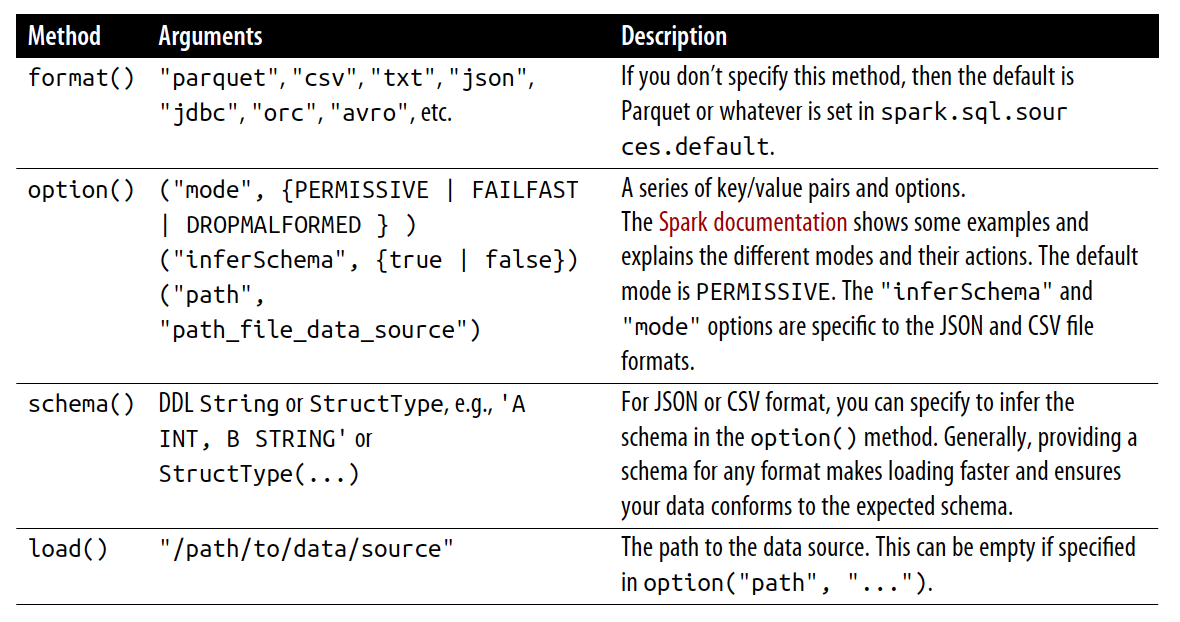

In [1]:
from IPython.display import Image
Image(filename='../UI_screenshots/DFR/dfr.png',width=600,height=10)

# Read Modes
PERMISSIVE - Default - Nulls are inserted for fields which cannot be parsed correctly  
DROPMALFORMED - drops records with fields that could not be parsed  
FAILFAST - Stops reading if any error data is found  


Permissive mode - Inspect incorrect rows using:  
- Provide custom path to option badRecordsPath to record corrupt records to a file
- Add column _corrupt_record to schema for review

In [4]:
diamonds_df = spark.read.format("csv").option("inferschema","true").option("header","true").option("mode", "PERMISSIVE").load('data/diamonds.csv')

In [5]:
diamonds_df.show()

+-----+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|index|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+-----+---------+-----+-------+-----+-----+-----+----+----+----+
|    1| 0.23|    Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
|    2| 0.21|  Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
|    3| 0.23|     Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
|    4| 0.29|  Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
|    5| 0.31|     Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
|    6| 0.24|Very Good|    J|   VVS2| 62.8| 57.0|  336|3.94|3.96|2.48|
|    7| 0.24|Very Good|    I|   VVS1| 62.3| 57.0|  336|3.95|3.98|2.47|
|    8| 0.26|Very Good|    H|    SI1| 61.9| 55.0|  337|4.07|4.11|2.53|
|    9| 0.22|     Fair|    E|    VS2| 65.1| 61.0|  337|3.87|3.78|2.49|
|   10| 0.23|Very Good|    H|    VS1| 59.4| 61.0|  338| 4.0|4.05|2.39|
|   11|  0.3|     Good|    J|    SI1| 64.0| 55.0|  339|4.25|4.28|2.73|
|   12

In [6]:
diamonds_df.count()

53940

In [7]:
from pyspark.sql.types import *

schema = StructType([
  StructField("index", IntegerType(), True),
  StructField("carat", DoubleType(), True),
  StructField("cut", StringType(), True),
  StructField("color", StringType(), True),
  StructField("clarity", StringType(), True),
  StructField("depth", IntegerType(), True), # The depth field is defined wrongly. The actual data contains floating point numbers, while the schema specifies an integer.
  StructField("table", DoubleType(), True),
  StructField("price", IntegerType(), True),
  StructField("x", DoubleType(), True),
  StructField("y", DoubleType(), True),
  StructField("z", DoubleType(), True),
  StructField("_corrupt_record", StringType(), True) #The schema contains a special column _corrupt_record, which does not exist in the data. This column captures rows that did not parse correctly.
])

In [8]:
perm_diamonds_df = spark.read.format("csv").option("header","true").schema(schema).option("mode", "PERMISSIVE").load('data/diamonds.csv')

In [9]:
# The mistake in the user-specified schema causes any row with a non-integer value in the depth column to be nullified.
# There are some rows, where the value of depth is an integer e.g. 64.0. They are parsed and coverted successfully.
# The _currupt_record column shows the string with original row data, which helps find the issue. 
perm_diamonds_df.show()

+-----+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------------------+
|index|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|     _corrupt_record|
+-----+-----+---------+-----+-------+-----+-----+-----+----+----+----+--------------------+
|    1| 0.23|    Ideal|    E|    SI2| NULL| 55.0|  326|3.95|3.98|2.43|"1",0.23,"Ideal",...|
|    2| 0.21|  Premium|    E|    SI1| NULL| 61.0|  326|3.89|3.84|2.31|"2",0.21,"Premium...|
|    3| 0.23|     Good|    E|    VS1| NULL| 65.0|  327|4.05|4.07|2.31|"3",0.23,"Good","...|
|    4| 0.29|  Premium|    I|    VS2| NULL| 58.0|  334| 4.2|4.23|2.63|"4",0.29,"Premium...|
|    5| 0.31|     Good|    J|    SI2| NULL| 58.0|  335|4.34|4.35|2.75|"5",0.31,"Good","...|
|    6| 0.24|Very Good|    J|   VVS2| NULL| 57.0|  336|3.94|3.96|2.48|"6",0.24,"Very Go...|
|    7| 0.24|Very Good|    I|   VVS1| NULL| 57.0|  336|3.95|3.98|2.47|"7",0.24,"Very Go...|
|    8| 0.26|Very Good|    H|    SI1| NULL| 55.0|  337|4.07|4.11|2.53|"8",0.26,"

In [10]:
perm_diamonds_df.count()

53940

Dropmalformed mode

In [11]:
malf_diamonds_df = spark.read.format("csv").option("header","true").schema(schema).option("mode", "DROPMALFORMED").load('data/diamonds.csv')

In [12]:
malf_diamonds_df.show()

+-----+-----+---------+-----+-------+-----+-----+-----+----+----+----+---------------+
|index|carat|      cut|color|clarity|depth|table|price|   x|   y|   z|_corrupt_record|
+-----+-----+---------+-----+-------+-----+-----+-----+----+----+----+---------------+
|   11|  0.3|     Good|    J|    SI1|   64| 55.0|  339|4.25|4.28|2.73|           NULL|
|   17|  0.3|    Ideal|    I|    SI2|   62| 54.0|  348|4.31|4.34|2.68|           NULL|
|   23| 0.23|Very Good|    H|    VS1|   61| 57.0|  353|3.94|3.96|2.41|           NULL|
|   31| 0.23|Very Good|    F|    VS1|   60| 57.0|  402| 4.0|4.03|2.41|           NULL|
|   38| 0.31|     Good|    H|    SI1|   64| 54.0|  402|4.29|4.31|2.75|           NULL|
|   56|  0.3|    Ideal|    I|    SI2|   61| 59.0|  405| 4.3|4.33|2.63|           NULL|
|   59|  0.3|Very Good|    I|    SI1|   63| 57.0|  405|4.28|4.32|2.71|           NULL|
|   67| 0.32|    Ideal|    I|   VVS1|   62| 55.3|  553|4.39|4.42|2.73|           NULL|
|  107|  0.8|  Premium|    G|    SI1|   63|

Failfast mode

In [13]:
ff_diamonds_df = spark.read.format("csv").option("header","true").schema(schema).option("mode", "FAILFAST").load('data/diamonds.csv')

In [14]:
ff_diamonds_df.show()

24/12/06 15:26:10 ERROR Executor: Exception in task 0.0 in stage 11.0 (TID 9)
org.apache.spark.SparkException: Encountered error while reading file file:///Users/saitejadevalla/Desktop/SaiTeja/GitHub_Repos/All_things_Spark/data/diamonds.csv. Details:
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFilesError(QueryExecutionErrors.scala:864)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scal

Py4JJavaError: An error occurred while calling o68.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11.0 failed 1 times, most recent failure: Lost task 0.0 in stage 11.0 (TID 9) (saismacbookair.attlocal.net executor driver): org.apache.spark.SparkException: Encountered error while reading file file:///Users/saitejadevalla/Desktop/SaiTeja/GitHub_Repos/All_things_Spark/data/diamonds.csv. Details:
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFilesError(QueryExecutionErrors.scala:864)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: [MALFORMED_RECORD_IN_PARSING.WITHOUT_SUGGESTION] Malformed records are detected in record parsing: [1,0.23,Ideal,E,SI2,null,55.0,326,3.95,3.98,2.43,"1",0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43].
Parse Mode: FAILFAST. To process malformed records as null result, try setting the option 'mode' as 'PERMISSIVE'. 
	at org.apache.spark.sql.errors.QueryExecutionErrors$.malformedRecordsDetectedInRecordParsingError(QueryExecutionErrors.scala:1611)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:79)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$2(UnivocityParser.scala:457)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:283)
	... 22 more
Caused by: org.apache.spark.sql.catalyst.util.BadRecordException: java.lang.NumberFormatException: For input string: "61.5"
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:366)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$parse$2(UnivocityParser.scala:308)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$1(UnivocityParser.scala:453)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:60)
	... 28 more
Caused by: java.lang.NumberFormatException: For input string: "61.5"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:65)
	at java.base/java.lang.Integer.parseInt(Integer.java:652)
	at java.base/java.lang.Integer.parseInt(Integer.java:770)
	at scala.collection.immutable.StringLike.toInt(StringLike.scala:310)
	at scala.collection.immutable.StringLike.toInt$(StringLike.scala:310)
	at scala.collection.immutable.StringOps.toInt(StringOps.scala:33)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6(UnivocityParser.scala:190)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6$adapted(UnivocityParser.scala:190)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.nullSafeDatum(UnivocityParser.scala:292)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$5(UnivocityParser.scala:190)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:347)
	... 31 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:530)
	at org.apache.spark.sql.execution.SparkPlan.executeTake(SparkPlan.scala:483)
	at org.apache.spark.sql.execution.CollectLimitExec.executeCollect(limit.scala:61)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4333)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3316)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3539)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Encountered error while reading file file:///Users/saitejadevalla/Desktop/SaiTeja/GitHub_Repos/All_things_Spark/data/diamonds.csv. Details:
	at org.apache.spark.sql.errors.QueryExecutionErrors$.cannotReadFilesError(QueryExecutionErrors.scala:864)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:293)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:388)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:893)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:893)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.SparkException: [MALFORMED_RECORD_IN_PARSING.WITHOUT_SUGGESTION] Malformed records are detected in record parsing: [1,0.23,Ideal,E,SI2,null,55.0,326,3.95,3.98,2.43,"1",0.23,"Ideal","E","SI2",61.5,55,326,3.95,3.98,2.43].
Parse Mode: FAILFAST. To process malformed records as null result, try setting the option 'mode' as 'PERMISSIVE'. 
	at org.apache.spark.sql.errors.QueryExecutionErrors$.malformedRecordsDetectedInRecordParsingError(QueryExecutionErrors.scala:1611)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:79)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$2(UnivocityParser.scala:457)
	at scala.collection.Iterator$$anon$11.nextCur(Iterator.scala:486)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:492)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.hasNext(FileScanRDD.scala:129)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.nextIterator(FileScanRDD.scala:283)
	... 22 more
Caused by: org.apache.spark.sql.catalyst.util.BadRecordException: java.lang.NumberFormatException: For input string: "61.5"
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:366)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$parse$2(UnivocityParser.scala:308)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser$.$anonfun$parseIterator$1(UnivocityParser.scala:453)
	at org.apache.spark.sql.catalyst.util.FailureSafeParser.parse(FailureSafeParser.scala:60)
	... 28 more
Caused by: java.lang.NumberFormatException: For input string: "61.5"
	at java.base/java.lang.NumberFormatException.forInputString(NumberFormatException.java:65)
	at java.base/java.lang.Integer.parseInt(Integer.java:652)
	at java.base/java.lang.Integer.parseInt(Integer.java:770)
	at scala.collection.immutable.StringLike.toInt(StringLike.scala:310)
	at scala.collection.immutable.StringLike.toInt$(StringLike.scala:310)
	at scala.collection.immutable.StringOps.toInt(StringOps.scala:33)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6(UnivocityParser.scala:190)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$6$adapted(UnivocityParser.scala:190)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.nullSafeDatum(UnivocityParser.scala:292)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.$anonfun$makeConverter$5(UnivocityParser.scala:190)
	at org.apache.spark.sql.catalyst.csv.UnivocityParser.org$apache$spark$sql$catalyst$csv$UnivocityParser$$convert(UnivocityParser.scala:347)
	... 31 more


In [15]:
spark.stop()